In [444]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import librosa
import librosa.display
import IPython.display as ipd

from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [291]:
#hoplength=10000

In [636]:
def calculate_mfccs(waveform, samplingrate, number_coeffs=128, hoplength=1000):
    '''
    Caluculate Mel frequency cepstral coefficients.
    Input:
    waveform: array representing the waveform originating from audio file
    samplingrate: sampling rate from audio
    number_coeffs: total number of coefficients to calculate, default is 20
    Output: array of mfccs
    '''
    mfccs = librosa.feature.mfcc(y=waveform, sr=samplingrate,
                                 n_mfcc=number_coeffs, hop_length=hoplength)
    return mfccs


def calculate_specbandwidth(waveform, samplingrate, order_p=2, wind=10, hoplength=1000):
    '''
    Calculates spectral bandwithd of oder p
    '''
    specbw = librosa.feature.spectral_bandwidth(y=waveform, sr=samplingrate,
                                                p=order_p, hop_length=hoplength)

    return specbw


def calculate_spectralcentroid(waveform, samplingrate, nfft=2048, hoplength=1000):
    '''
    Calculate spectral centroid
    '''
    specent = librosa.feature.spectral_centroid(y=waveform,
                                                sr=samplingrate, n_fft=nfft,
                                                hop_length=hoplength)

    return specent


def calculate_chroma(waveform, samplingrate, nfft=2048, hoplength=1000):
    '''
    Chroma Feature calculation with a hop length of 512 as default

    '''
    chromafeat = librosa.feature.chroma_stft(y=waveform, sr=samplingrate,
                                             n_fft=nfft,
                                             hop_length=hoplength)

    return chromafeat


def calculate_zerocrossrate(waveform, framelength=2048, hoplength=1000):
    '''
    Caluculate Zero crossing rate.

    '''
    zerocr = librosa.feature.zero_crossing_rate(y=waveform, frame_length=framelength,
                                                hop_length=hoplength)

    return zerocr


def calculate_spectralroff(waveform, samplingrate, nfft=2048, hoplength=1000):
    '''
    Calculate spectral roll off of the waveform
    '''
    specroff = librosa.feature.spectral_rolloff(y=waveform,
                                                sr=samplingrate, n_fft=nfft,
                                                hop_length=hoplength)

    return specroff

def normalize(array):
    ''' 
    simple function to normalize an array
    requires an array as input, returns a normalized array
    '''
    return array / np.linalg.norm(array)

In [293]:
 # x, sr = reading_audiofile("example3.wav")

In [637]:
def get_add_features(x, sr):
    '''
    Extracts all additional features of a given sample (x: nd-array 1-dim , sr: sample rate)
    returns following arrays: mfcc, specbandwith, spectralcentroid, chroma, zeorcrossrate, spectralroff
    '''
    specbandwith = calculate_specbandwidth(x, sr, order_p=2, wind=10, hoplength=1000)  # shape(1,70)
    mfcc = calculate_mfccs(x, sr, number_coeffs=20, )   # changed number_coeffs to 20  -> #shape (20,70)
    specbandwith = calculate_specbandwidth(x, sr, order_p=2, wind=10, hoplength=1000)  # shape(1,70)
    spectralcentroid = calculate_spectralcentroid(x, sr, nfft=2048, hoplength=1000)  #(shape1,70)
    chroma = calculate_chroma(x, sr, nfft=2048, hoplength=1000) # shape (12,70)
    zerocrossrate = calculate_zerocrossrate(x, framelength=2048, hoplength=1000) #shape (1,70)
    spectralroff = calculate_spectralroff(x, sr, nfft=2048, hoplength=1000) #shape (1,70)
    
    return mfcc, specbandwith, spectralcentroid, chroma, zerocrossrate, spectralroff


def extracting_add_features(list_from_db, desired_length=6, pause=1, num_steps=3):
    '''
    Extracts all additional features (with gett_add_features function) of a list (provided by list_from_db function)
    Requires list, desired_length in sec (default 6 sec), pause in sec (for repeat-padding, default 1 sec)
    
    returns a dictionary with keys: mfcc, specbandwith, spectralcentroid, chroma, zeorcrossrate, spectralroff, style, bpm
                        each contains a list (with features of all samples from list_from_db)
    '''
    
    
    feat_dict = {'mfcc':[], 'specbandwith':[], 'spectralcentroid':[], 'chroma':[],
                         'zerocrossrate':[], 'spectralroff':[], 'style':[], 'bpm':[]}
    for audio_sample in list_from_db:
        filename = path + audio_sample[1]
        length = audio_sample[0]
        style = audio_sample[2]
        bpm = audio_sample[3]
        
        if length < desired_length: 
            x, sr = reading_audiofile(filename, modus_operandi="repeat",
                              desired_length=desired_length, offset=0.0, pause=pause)
            mfcc, specbandwith, spectralcentroid, chroma, zerocrossrate, spectralroff = get_add_features(x, sr)
            feat_dict['mfcc'].append(mfcc)
            feat_dict['specbandwith'].append(specbandwith)
            feat_dict['spectralcentroid'].append(spectralcentroid)
            feat_dict['chroma'].append(chroma)
            feat_dict['zerocrossrate'].append(zerocrossrate)
            feat_dict['spectralroff'].append(spectralroff)
            feat_dict['style'].append(style)
            feat_dict['bpm'].append(bpm)
            
                      
        if length > desired_length:
            steps=int(length//desired_length)
            if steps > (num_steps -1):
                steps = (num_steps -1)
            for i in range(steps):
                x, sr = reading_audiofile(filename, modus_operandi="no_change",
                            desired_length=desired_length, offset=i*desired_length)
                mfcc, specbandwith, spectralcentroid, chroma, zerocrossrate, spectralroff = get_add_features(x, sr)
                feat_dict['mfcc'].append(mfcc)
                feat_dict['specbandwith'].append(specbandwith)
                feat_dict['spectralcentroid'].append(spectralcentroid)
                feat_dict['chroma'].append(chroma)
                feat_dict['zerocrossrate'].append(zerocrossrate)
                feat_dict['spectralroff'].append(spectralroff) 
                feat_dict['style'].append(style)
                feat_dict['bpm'].append(bpm)
                
            x, sr = reading_audiofile(filename, modus_operandi="repeat",
                                desired_length=desired_length, offset=steps*desired_length, pause=pause)
            mfcc, specbandwith, spectralcentroid, chroma, zerocrossrate, spectralroff = get_add_features(x, sr)
            feat_dict['mfcc'].append(mfcc)
            feat_dict['specbandwith'].append(specbandwith)
            feat_dict['spectralcentroid'].append(spectralcentroid)
            feat_dict['chroma'].append(chroma)
            feat_dict['zerocrossrate'].append(zerocrossrate)
            feat_dict['spectralroff'].append(spectralroff)  
            feat_dict['style'].append(style)
            feat_dict['bpm'].append(bpm)
                
    return feat_dict
    
    
def add_features_as_array_for_CNN(feat_dict_normalized):
    '''
    requires a dictionary with additional features already NORMALIZED (mfcc, specbandwith, spectralcentroid, 
            chroma, zerocrossrate, spectralroff) and not normalized (style = y) and bpm (no need to normalize?)
            
    returns a dictionary with keys: array (putting together all additional features in a single array:
                                             specbandwith, spectralcentroid,
                                            chroma, zeorcrossrate, spectralroff)
                                    style,
                                    bpm
                        each contains a list 
                        
    '''
    length = len(feat_dict['style'])
    cnn_add_feat_dict = {'feat_array':[],'stype':[],'bpm':[]}
    for i in range(length):
        style = feat_dict_normalized['style'][i]
        bpm = feat_dict_normalized['bpm'][i]
        feat_array = np.concatenate(
            feat_dict_normalized['norm_mfcc'][i],
            feat_dict_normalized['norm_specbandwith'][i],
            feat_dict_normalized['norm_spectralcentroid'][i],
            feat_dict_normalized['norm_chroma'][i],
            feat_dict_normalized['norm_zerocrossrate'][i],
            feat_dict_normalized['norm_spectralroff'][i],)
        cnn_add_feat_dict[feat_array].append(feat_array)
        cnn_add_feat_dict[style].append(style)
        cnn_add_feat_dict[bpm].append(bpm)
            
    return cnn_add_feat_dict

In [316]:
# db_audio = pd.read_csv(path + "info.csv")


def list_from_db(db_audio):
    list_of_samples = []
    for dataset in db_audio.iterrows():
        if dataset[1].beat_type=="beat":
            list_of_samples.append((dataset[1].duration, dataset[1].audio_filename, dataset[1].style, dataset[1].bpm))
    return list_of_samples

#list_from_db = list_from_db(db_audio)


def extracting_spectograms(list_from_db, desired_length, pause=1):
    preprocessed_data = []
    for audio_sample in list_from_db:
        filename = path + audio_sample[1]
        length = audio_sample[0]
        style = audio_sample[2]
        bpm = audio_sample[3]
        
        if length < desired_length: 
            x, sr = reading_audiofile(filename, modus_operandi="repeat",
                              desired_length=desired_length, offset=0.0, pause=pause)
            Xdb = spectogram(x, sr)
            preprocessed_data.append([Xdb, style, bpm])
            
        if length > desired_length:
            steps=int(length//desired_length)
            for i in range(steps):
                x, sr = reading_audiofile(filename, modus_operandi="no_change",
                            desired_length=desired_length, offset=i*desired_length)
                Xdb = spectogram(x, sr)
                preprocessed_data.append([Xdb, style, bpm])
                
            x, sr = reading_audiofile(filename, modus_operandi="repeat",
                                desired_length=desired_length, offset=steps*desired_length, pause=pause)
            Xdb = spectogram(x, sr)
            preprocessed_data.append([Xdb, style, bpm])
                
    return preprocessed_data

#prepoc=extracting_spectograms(list_from_db, desired_length=6, pause=1)

def reading_audiofile(filename, modus_operandi="no_change", desired_length=6, offset=0.0, pause=1):
    ''' reading in audiofiles
        requires filename (with path)
                modus_operandi:  "no_change" -> reading in audiofile in length, no padding
                                 "silence"-> padding smaller (than desired length) audio files with silence
                                 "repeat" -> padding smaller audio files with repetitive sound (+ pauses)
                desired_length:  in sec, if prespecified length is requested (default value 30)
                                 does not apply if "no_change" modus is chosen
                pause:           in sec, if modus "repeat" is chosen: if a pause between repetions is asked
        returns x (nd-array), sr (sample rate)
    '''

    if modus_operandi=="no_change":
         x , sr = librosa.load(filename, duration=desired_length, offset=0.0)

    if modus_operandi=="repeat":
        # == filling up smaller samples with repeated sounds ==
        x , sr = librosa.load(filename, duration= desired_length, offset=0.0)
        duration = x.shape[0]/sr        # in seconds
        if duration < desired_length:
            pause = int(pause * sr)     # seconds (first number) * sampling rate
            multiplier = int(desired_length // duration)
            single_x=np.append(np.zeros(pause),x)
            for i in range(multiplier):
                x = np.append(x, single_x)
            x=x[0:desired_length*sr]

    if modus_operandi=="silence":
        # == filling up smaller samples with silence ==
        x , sr = librosa.load(filename, duration= desired_length)
        duration = x.shape[0]/22000        # in seconds
        if duration < desired_length:
            filling_zeros = desired_length * sr - x.shape[0]
            x = np.append(x, np.zeros(filling_zeros))
            x=x[0:desired_length*sr]

    return x, sr

def spectogram(x, sr):
    ''' 
===  1 Spectogram  ===
 requires 1-dimensional array x(timeseries), sampling rate sr
 returns a vector of spectogram
    '''
    #performing short time- Fourier analysis
    X = librosa.stft(x)

    #amplitudes of given frequency at given time -> spectrogram
    Xdb = librosa.amplitude_to_db(abs(X))

    #plt.figure(figsize=(10, 10), dpi=50, frameon=False)
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') # for demonstration purposes
    #spect_audio = librosa.display.specshow(Xdb, sr=sr, x_axis=None, y_axis=None, cmap="Greys") # without axes
    return Xdb

In [638]:
def strip_genre(df):
    df.split()

In [639]:
path = '../raw_data/groove/'

In [640]:
db = pd.read_csv(path + "info.csv")
# db_audio = db_audio.iloc[0:10]
db.head()

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test


In [641]:
df_audio = db.drop(columns=['drummer', 'id', 'session', 'split', 'midi_filename'])
df_audio.head()

,style,bpm,beat_type,time_signature,audio_filename,duration
0,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308
1,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158
2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218
3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543
4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500


In [642]:
df_audio = df_audio[df_audio['beat_type'] == 'beat']
df_audio = df_audio.dropna()

In [643]:
df_audio['style'] = df_audio['style'].apply(lambda x: x.split('/')[0]) 
# df_audio.groupby(by='style_new').count()
# df_audio['style'] = df_audio['style_new']  

In [644]:
df_audio.head()

,style,bpm,beat_type,time_signature,audio_filename,duration
0,funk,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308
1,soul,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158
2,funk,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218
3,soul,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543
4,soul,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500


In [645]:
df_train, df_test = train_test_split(df_audio, test_size=0.2, random_state=7)

In [646]:
list_from_db = list_from_db(df_train)

TypeError: 'list' object is not callable

In [647]:
len(list_from_db)

355

In [648]:
dictionary = extracting_add_features(list_from_db[0:50])

In [649]:
dictionary.keys()

dict_keys(['mfcc', 'specbandwith', 'spectralcentroid', 'chroma', 'zerocrossrate', 'spectralroff', 'style', 'bpm'])

In [650]:
len(dictionary['style'])

134

In [651]:
len(dictionary['specbandwith'])

134

In [652]:
dictionary['chroma'][0].shape

(12, 133)

In [653]:
dictionary['mfcc'][0].shape

(20, 133)

In [654]:
dictionary['specbandwith'][0].shape

(1, 133)

In [655]:
df = pd.DataFrame.from_dict(dictionary)
df['chroma'][0].shape

(12, 133)

# Mean and standard deviation

In [24]:
df.head(1)

,mfcc,specbandwith,spectralcentroid,chroma,zerocrossrate,spectralroff,style,bpm
0,"[[-260.77158, -251.04285, -269.42813, -292.240...","[[3410.3093764508108, 3396.535848879602, 3230....","[[4974.285762405871, 5305.890006700972, 5686.2...","[[0.80164516, 0.48341665, 0.2846054, 0.3002181...","[[0.18359375, 0.2685546875, 0.36376953125, 0.4...","[[9011.6455078125, 9140.8447265625, 9259.27734...",jazz,125


## Simplified model with mean of means for 2-dimensional features

### Feature engineering

In [557]:
X_mean = df.drop(columns=['mfcc', 'chroma', 'style', 'bpm'])

In [558]:
empty_df = pd.DataFrame()
for column in X_mean.columns:
    empty_df[f'{column} mean'] = [X_mean[column][i][0].mean() for i in range(len(X[column]))]
    empty_df[f'{column} std'] = [X_mean[column][i][0].std() for i in range(len(X[column]))]
for column in ['mfcc', 'chroma']:
    empty_df[f'{column} mean'] = [df[column][j].mean(axis=1).mean() for j in range(len(df[column]))]
    empty_df[f'{column} std'] = [df[column][j].std(axis=1).mean() for j in range(len(df[column]))]

KeyError: 'specbandwith'

In [ ]:
X_mean = empty_df
y = df['style']

In [546]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
labelencoder=LabelEncoder()
labelencoder.fit(y)
y_transformed = labelencoder.transform(y)


y_cat = to_categorical(y_transformed)
y_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

### Model Cross-validation

#### KNN Classifier

In [547]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

knn_model = KNeighborsClassifier()
cv_results = cross_validate(knn_model, X_mean, y_cat, cv=5, scoring=('accuracy', 'f1_samples'))

ValueError: Found input variables with inconsistent numbers of samples: [134, 964]

In [543]:
accuracy = cv_results['test_accuracy'].mean()
accuracy

0.23125

#### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_mean, y_cat)

cv_forest = cross_validate(random_forest, X, y_cat, cv=5, scoring=('accuracy', 'f1_samples'))
forest_accuracy = cv_forest['test_accuracy'].mean()
forest_f1 = cv_forest['test_f1_samples'].mean()

print('accuracy =', forest_accuracy)
print('f1 =', forest_f1)

accuracy = 0.19187715889464593
f1 = 0.19187715889464593


#### Gradient Boosting Classifier

In [32]:
y_cat.shape

(964, 17)

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier


gradient_classifier = MultiOutputClassifier(GradientBoostingClassifier())
gradient_classifier.fit(X_mean, y_cat)

cv_gradient = cross_validate(gradient_classifier, X, y_cat, cv=5, scoring=('accuracy', 'f1_samples'), error_score='raise')
gradient_accuracy = cv_gradient['test_accuracy'].mean()
gradient_f1 = cv_gradient['test_f1_samples'].mean()

print('accuracy =', gradient_accuracy)
print('f1 =', gradient_f1)


ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

In [ ]:
cv_gradient

#### XGBClassifier

In [541]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier


classifier = MultiOutputClassifier(XGBClassifier())

classifier.fit(X_mean, y_cat)

cv_xgb = cross_validate(classifier, X_mean, y_cat, cv=5, scoring=('accuracy', 'f1_samples'))
xgb_accuracy = cv_xgb['test_accuracy'].mean()
xgb_f1 = cv_xgb['test_f1_samples'].mean()

print('accuracy =', xgb_accuracy)
print('f1 =', xgb_f1)

/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoostError: [13:05:30] /Users/runner/work/xgboost/xgboost/src/data/data.cc:592: Check failed: labels_.Size() == num_row_ (964 vs. 134) : Size of labels must equal to number of rows.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000169815814 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x00000001698660c8 xgboost::MetaInfo::Validate(int) const + 1288
  [bt] (2) 3   libxgboost.dylib                    0x00000001698c9f7c xgboost::LearnerImpl::ValidateDMatrix(xgboost::DMatrix*, bool) const + 44
  [bt] (3) 4   libxgboost.dylib                    0x00000001698b9df1 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 273
  [bt] (4) 5   libxgboost.dylib                    0x000000016980ab19 XGBoosterUpdateOneIter + 137
  [bt] (5) 6   libffi.dylib                        0x00007fff2d9e28f5 ffi_call_unix64 + 85
  [bt] (6) 7   ???                                 0x00007ffee4e4a440 0x0 + 140732738610240



## Model with means of columns for 2-dimensional features

In [ ]:
df['mfcc'][1].mean(axis=1)

# All features + PCA

### Feature engineering

In [656]:
X_one = df.drop(columns=['mfcc', 'chroma', 'style', 'bpm'])
X_one.columns

Index(['specbandwith', 'spectralcentroid', 'zerocrossrate', 'spectralroff'], dtype='object')

In [657]:
X_one

,specbandwith,spectralcentroid,zerocrossrate,spectralroff
0,"[[3410.3093764508108, 3237.5360334299007, 3240...","[[4974.285762405871, 5673.871200589587, 5796.3...","[[0.18359375, 0.3583984375, 0.4462890625, 0.52...","[[9011.6455078125, 9248.5107421875, 9420.77636..."
1,"[[3410.3093764508108, 3237.5360334299007, 3240...","[[4974.285762405871, 5673.871200589587, 5796.3...","[[0.18359375, 0.3583984375, 0.4462890625, 0.52...","[[9011.6455078125, 9248.5107421875, 9420.77636..."
2,"[[3410.3093764508108, 3237.5360334299007, 3240...","[[4974.285762405871, 5673.871200589587, 5796.3...","[[0.18359375, 0.3583984375, 0.4462890625, 0.52...","[[9011.6455078125, 9248.5107421875, 9420.77636..."
3,"[[3747.8921267843334, 3733.4368342260464, 3653...","[[4089.7779437804065, 3862.3055350727723, 3407...","[[0.125, 0.1474609375, 0.05224609375, 0.041015...","[[8947.0458984375, 8742.48046875, 8397.9492187..."
4,"[[3747.8921267843334, 3733.4368342260464, 3653...","[[4089.7779437804065, 3862.3055350727723, 3407...","[[0.125, 0.1474609375, 0.05224609375, 0.041015...","[[8947.0458984375, 8742.48046875, 8397.9492187..."
...,...,...,...,...
129,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
130,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
131,"[[3651.3439409116513, 3626.0174455427805, 3661...","[[4302.515826682538, 3200.2829063719137, 3340....","[[0.13671875, 0.19384765625, 0.0751953125, 0.0...","[[8860.9130859375, 8333.349609375, 8451.782226..."
132,"[[3651.3439409116513, 3626.0174455427805, 3661...","[[4302.515826682538, 3200.2829063719137, 3340....","[[0.13671875, 0.19384765625, 0.0751953125, 0.0...","[[8860.9130859375, 8333.349609375, 8451.782226..."


In [658]:
def create_empty_DataFrame(name, dataframe):
    return pd.DataFrame(dataframe[name], columns= [f'{name} {n}' for n in range(len(dataframe[name][0][0]))])

In [659]:
#specbandwith_df = pd.DataFrame(df['specbandwith'], columns= [f'specbandwith {n}' for n in range(len(df['specbandwith'][0][0]))])

In [660]:
specbandwith_df = create_empty_DataFrame('specbandwith', X_one)
spectralcentroid_df = create_empty_DataFrame('spectralcentroid', X_one)
zerocrossrate_df = create_empty_DataFrame('zerocrossrate', X_one)
spectralroff_df = create_empty_DataFrame('spectralroff', X_one)


In [661]:
for i in range(len(X_one['specbandwith'])):
    specbandwith_df.loc[len(specbandwith_df.index)] = X_one['specbandwith'][i][0].T
for i in range(len(X_one['spectralcentroid'])):
    spectralcentroid_df.loc[len(spectralcentroid_df.index)] = X_one['spectralcentroid'][i][0].T
for i in range(len(X_one['zerocrossrate'])):
    zerocrossrate_df.loc[len(zerocrossrate_df.index)] = X_one['zerocrossrate'][i][0].T
for i in range(len(X_one['spectralroff'])):
    spectralroff_df.loc[len(spectralroff_df.index)] = X_one['spectralroff'][i][0].T

In [662]:
specbandwith_df

,specbandwith 0,specbandwith 1,specbandwith 2,specbandwith 3,specbandwith 4,specbandwith 5,specbandwith 6,specbandwith 7,specbandwith 8,specbandwith 9,...,specbandwith 123,specbandwith 124,specbandwith 125,specbandwith 126,specbandwith 127,specbandwith 128,specbandwith 129,specbandwith 130,specbandwith 131,specbandwith 132
0,3410.309376,3237.536033,3240.005979,3109.448420,3104.149513,3263.962845,3288.783941,3560.348643,3540.294795,3507.600891,...,2821.636488,2803.931923,2777.186286,2814.214538,2716.012210,2725.959717,2670.313964,2830.533200,2879.919394,2775.269470
1,3410.309376,3237.536033,3240.005979,3109.448420,3104.149513,3263.962845,3288.783941,3560.348643,3540.294795,3507.600891,...,2821.636488,2803.931923,2777.186286,2814.214538,2716.012210,2725.959717,2670.313964,2830.533200,2879.919394,2775.269470
2,3410.309376,3237.536033,3240.005979,3109.448420,3104.149513,3263.962845,3288.783941,3560.348643,3540.294795,3507.600891,...,2821.636488,2803.931923,2777.186286,2814.214538,2716.012210,2725.959717,2670.313964,2830.533200,2879.919394,2775.269470
3,3747.892127,3733.436834,3653.546912,3340.704393,3635.275888,3465.979899,2807.993604,3011.436325,3081.973331,3293.404402,...,3710.278150,3719.791487,3694.237212,3355.305603,3670.499770,3683.396984,3288.532740,3466.863051,3290.798305,3519.276511
4,3747.892127,3733.436834,3653.546912,3340.704393,3635.275888,3465.979899,2807.993604,3011.436325,3081.973331,3293.404402,...,3710.278150,3719.791487,3694.237212,3355.305603,3670.499770,3683.396984,3288.532740,3466.863051,3290.798305,3519.276511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2810.857082,2861.756841,2779.277468,2634.326009,3077.504075,2999.428028,2857.848556,2176.076431,2834.188444,3046.074410
130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2810.857082,2861.756841,2779.277468,2634.326009,3077.504075,2999.428028,2857.848556,2176.076431,2834.188444,3046.074410
131,3651.343941,3626.017446,3661.639189,3658.827301,3704.796839,3570.487038,3559.632102,3645.513056,3072.688067,2996.575747,...,3170.380170,2930.028726,2820.308110,3624.191747,3620.399646,3669.025820,3636.537849,3654.078621,3370.901044,3648.888758
132,3651.343941,3626.017446,3661.639189,3658.827301,3704.796839,3570.487038,3559.632102,3645.513056,3072.688067,2996.575747,...,3170.380170,2930.028726,2820.308110,3624.191747,3620.399646,3669.025820,3636.537849,3654.078621,3370.901044,3648.888758


In [663]:
one_dim = specbandwith_df.join(spectralcentroid_df.join(zerocrossrate_df.join(spectralroff_df)))
one_dim

,specbandwith 0,specbandwith 1,specbandwith 2,specbandwith 3,specbandwith 4,specbandwith 5,specbandwith 6,specbandwith 7,specbandwith 8,specbandwith 9,...,spectralroff 123,spectralroff 124,spectralroff 125,spectralroff 126,spectralroff 127,spectralroff 128,spectralroff 129,spectralroff 130,spectralroff 131,spectralroff 132
0,3410.309376,3237.536033,3240.005979,3109.448420,3104.149513,3263.962845,3288.783941,3560.348643,3540.294795,3507.600891,...,9410.009766,9388.476562,9259.277344,9259.277344,9420.776367,9539.208984,9474.609375,9410.009766,9377.709961,9248.510742
1,3410.309376,3237.536033,3240.005979,3109.448420,3104.149513,3263.962845,3288.783941,3560.348643,3540.294795,3507.600891,...,9410.009766,9388.476562,9259.277344,9259.277344,9420.776367,9539.208984,9474.609375,9410.009766,9377.709961,9248.510742
2,3410.309376,3237.536033,3240.005979,3109.448420,3104.149513,3263.962845,3288.783941,3560.348643,3540.294795,3507.600891,...,9410.009766,9388.476562,9259.277344,9259.277344,9420.776367,9539.208984,9474.609375,9410.009766,9377.709961,9248.510742
3,3747.892127,3733.436834,3653.546912,3340.704393,3635.275888,3465.979899,2807.993604,3011.436325,3081.973331,3293.404402,...,8720.947266,8925.512695,8634.814453,7245.922852,8753.247070,8570.214844,6987.524414,9130.078125,9226.977539,9226.977539
4,3747.892127,3733.436834,3653.546912,3340.704393,3635.275888,3465.979899,2807.993604,3011.436325,3081.973331,3293.404402,...,8720.947266,8925.512695,8634.814453,7245.922852,8753.247070,8570.214844,6987.524414,9130.078125,9226.977539,9226.977539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7019.824219,7170.556641,7342.822266,6836.791992,9237.744141,8893.212891,8128.784180,2939.282227,4360.473633,6029.296875
130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7019.824219,7170.556641,7342.822266,6836.791992,9237.744141,8893.212891,8128.784180,2939.282227,4360.473633,6029.296875
131,3651.343941,3626.017446,3661.639189,3658.827301,3704.796839,3570.487038,3559.632102,3645.513056,3072.688067,2996.575747,...,9345.410156,9356.176758,9420.776367,9097.778320,9054.711914,8957.812500,9173.144531,8947.045898,9280.810547,8441.015625
132,3651.343941,3626.017446,3661.639189,3658.827301,3704.796839,3570.487038,3559.632102,3645.513056,3072.688067,2996.575747,...,9345.410156,9356.176758,9420.776367,9097.778320,9054.711914,8957.812500,9173.144531,8947.045898,9280.810547,8441.015625


In [664]:
two_dim = pd.DataFrame()
for column in ['mfcc', 'chroma']:
    two_dim[f'{column} mean'] = [df[column][j].mean(axis=0) for j in range(len(df[column]))]
    #two_dim[f'{column} std'] = [df[column][j].std(axis=1) for j in range(len(df[column]))]

In [665]:
two_dim

,mfcc mean,chroma mean
0,"[-3.637389, -3.4418902, -6.9178963, -9.807958,...","[0.6394132, 0.43783697, 0.52837676, 0.54281914..."
1,"[-3.637389, -3.4418902, -6.9178963, -9.807958,...","[0.6394132, 0.43783697, 0.52837676, 0.54281914..."
2,"[-3.637389, -3.4418902, -6.9178963, -9.807958,...","[0.6394132, 0.43783697, 0.52837676, 0.54281914..."
3,"[-5.2659893, -4.7855463, -10.484181, -13.90725...","[0.726685, 0.37872115, 0.27839854, 0.31327936,..."
4,"[-5.2659893, -4.7855463, -10.484181, -13.90725...","[0.726685, 0.37872115, 0.27839854, 0.31327936,..."
...,...,...
129,"[-32.935646, -32.935646, -32.935646, -32.93564...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
130,"[-32.935646, -32.935646, -32.935646, -32.93564...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
131,"[-5.5834947, 1.355385, -3.2522464, -6.9829865,...","[0.79220414, 0.43382183, 0.32900742, 0.3411717..."
132,"[-5.5834947, 1.355385, -3.2522464, -6.9829865,...","[0.79220414, 0.43382183, 0.32900742, 0.3411717..."


In [666]:
#mfcc_df = create_empty_DataFrame('mfcc mean', two_dim)
#chroma_df = create_empty_DataFrame('chroma mean', two_dim)

In [667]:
mfcc_df = pd.DataFrame(two_dim['mfcc mean'], columns= [f'mfcc mean {n}' for n in range(len(two_dim['mfcc mean'][0]))])
chroma_df = pd.DataFrame(two_dim['chroma mean'], columns= [f'chroma mean {n}' for n in range(len(two_dim['chroma mean'][0]))])

In [668]:
for i in range(len(two_dim['mfcc mean'])):
    mfcc_df.loc[len(mfcc_df.index)] = two_dim['mfcc mean'][i].T
for i in range(len(two_dim['chroma mean'])):
    chroma_df.loc[len(chroma_df.index)] = two_dim['chroma mean'][i].T

In [669]:
chroma_df

,chroma mean 0,chroma mean 1,chroma mean 2,chroma mean 3,chroma mean 4,chroma mean 5,chroma mean 6,chroma mean 7,chroma mean 8,chroma mean 9,...,chroma mean 123,chroma mean 124,chroma mean 125,chroma mean 126,chroma mean 127,chroma mean 128,chroma mean 129,chroma mean 130,chroma mean 131,chroma mean 132
0,0.639413,0.437837,0.528377,0.542819,0.666309,0.622654,0.526805,0.612189,0.446152,0.359997,...,0.574201,0.489195,0.506543,0.452370,0.416796,0.416645,0.414302,0.500449,0.542202,0.519943
1,0.639413,0.437837,0.528377,0.542819,0.666309,0.622654,0.526805,0.612189,0.446152,0.359997,...,0.574201,0.489195,0.506543,0.452370,0.416796,0.416645,0.414302,0.500449,0.542202,0.519943
2,0.639413,0.437837,0.528377,0.542819,0.666309,0.622654,0.526805,0.612189,0.446152,0.359997,...,0.574201,0.489195,0.506543,0.452370,0.416796,0.416645,0.414302,0.500449,0.542202,0.519943
3,0.726685,0.378721,0.278399,0.313279,0.588776,0.347663,0.461598,0.562928,0.724553,0.547081,...,0.638405,0.375642,0.293285,0.337463,0.601640,0.373607,0.437737,0.682456,0.730184,0.525892
4,0.726685,0.378721,0.278399,0.313279,0.588776,0.347663,0.461598,0.562928,0.724553,0.547081,...,0.638405,0.375642,0.293285,0.337463,0.601640,0.373607,0.437737,0.682456,0.730184,0.525892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.428511,0.347378,0.358926,0.334992,0.482111,0.431417,0.507486,0.876038,0.778392,0.767804
130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.428511,0.347378,0.358926,0.334992,0.482111,0.431417,0.507486,0.876038,0.778392,0.767804
131,0.792204,0.433822,0.329007,0.341172,0.439326,0.422719,0.581050,0.488685,0.620865,0.633455,...,0.554828,0.599325,0.490684,0.656781,0.365098,0.308794,0.399740,0.752117,0.670928,0.668383
132,0.792204,0.433822,0.329007,0.341172,0.439326,0.422719,0.581050,0.488685,0.620865,0.633455,...,0.554828,0.599325,0.490684,0.656781,0.365098,0.308794,0.399740,0.752117,0.670928,0.668383


In [670]:
X = one_dim.join(mfcc_df.join(chroma_df))
X

,specbandwith 0,specbandwith 1,specbandwith 2,specbandwith 3,specbandwith 4,specbandwith 5,specbandwith 6,specbandwith 7,specbandwith 8,specbandwith 9,...,chroma mean 123,chroma mean 124,chroma mean 125,chroma mean 126,chroma mean 127,chroma mean 128,chroma mean 129,chroma mean 130,chroma mean 131,chroma mean 132
0,3410.309376,3237.536033,3240.005979,3109.448420,3104.149513,3263.962845,3288.783941,3560.348643,3540.294795,3507.600891,...,0.574201,0.489195,0.506543,0.452370,0.416796,0.416645,0.414302,0.500449,0.542202,0.519943
1,3410.309376,3237.536033,3240.005979,3109.448420,3104.149513,3263.962845,3288.783941,3560.348643,3540.294795,3507.600891,...,0.574201,0.489195,0.506543,0.452370,0.416796,0.416645,0.414302,0.500449,0.542202,0.519943
2,3410.309376,3237.536033,3240.005979,3109.448420,3104.149513,3263.962845,3288.783941,3560.348643,3540.294795,3507.600891,...,0.574201,0.489195,0.506543,0.452370,0.416796,0.416645,0.414302,0.500449,0.542202,0.519943
3,3747.892127,3733.436834,3653.546912,3340.704393,3635.275888,3465.979899,2807.993604,3011.436325,3081.973331,3293.404402,...,0.638405,0.375642,0.293285,0.337463,0.601640,0.373607,0.437737,0.682456,0.730184,0.525892
4,3747.892127,3733.436834,3653.546912,3340.704393,3635.275888,3465.979899,2807.993604,3011.436325,3081.973331,3293.404402,...,0.638405,0.375642,0.293285,0.337463,0.601640,0.373607,0.437737,0.682456,0.730184,0.525892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.428511,0.347378,0.358926,0.334992,0.482111,0.431417,0.507486,0.876038,0.778392,0.767804
130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.428511,0.347378,0.358926,0.334992,0.482111,0.431417,0.507486,0.876038,0.778392,0.767804
131,3651.343941,3626.017446,3661.639189,3658.827301,3704.796839,3570.487038,3559.632102,3645.513056,3072.688067,2996.575747,...,0.554828,0.599325,0.490684,0.656781,0.365098,0.308794,0.399740,0.752117,0.670928,0.668383
132,3651.343941,3626.017446,3661.639189,3658.827301,3704.796839,3570.487038,3559.632102,3645.513056,3072.688067,2996.575747,...,0.554828,0.599325,0.490684,0.656781,0.365098,0.308794,0.399740,0.752117,0.670928,0.668383


In [ ]:
#df['specbandwith'][0].T

In [ ]:
#range(len(df['specbandwith']))

In [ ]:
#len(df['mfcc'][0][0])

### PCA Analysis

In [676]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)
X

,specbandwith 0,specbandwith 1,specbandwith 2,specbandwith 3,specbandwith 4,specbandwith 5,specbandwith 6,specbandwith 7,specbandwith 8,specbandwith 9,...,chroma mean 123,chroma mean 124,chroma mean 125,chroma mean 126,chroma mean 127,chroma mean 128,chroma mean 129,chroma mean 130,chroma mean 131,chroma mean 132
0,0.775714,0.562489,0.590149,0.610015,0.702838,0.837781,0.841278,1.023865,1.015483,1.053890,...,0.434797,0.010521,0.100754,-0.293862,-0.364072,-0.427014,-0.369264,-0.009048,-0.075715,-0.307574
1,0.775714,0.562489,0.590149,0.610015,0.702838,0.837781,0.841278,1.023865,1.015483,1.053890,...,0.434797,0.010521,0.100754,-0.293862,-0.364072,-0.427014,-0.369264,-0.009048,-0.075715,-0.307574
2,0.775714,0.562489,0.590149,0.610015,0.702838,0.837781,0.841278,1.023865,1.015483,1.053890,...,0.434797,0.010521,0.100754,-0.293862,-0.364072,-0.427014,-0.369264,-0.009048,-0.075715,-0.307574
3,1.013221,0.911812,0.884324,0.782423,1.113939,0.996180,0.459782,0.596497,0.660665,0.883615,...,0.789263,-0.631367,-1.069131,-0.907547,0.806675,-0.662879,-0.240663,0.891684,1.062216,-0.269500
4,1.013221,0.911812,0.884324,0.782423,1.113939,0.996180,0.459782,0.596497,0.660665,0.883615,...,0.789263,-0.631367,-1.069131,-0.907547,0.806675,-0.662879,-0.240663,0.891684,1.062216,-0.269500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,-1.623622,-1.718101,-1.714647,-1.708169,-1.699829,-1.721458,-1.768296,-1.748121,-1.725301,-1.734472,...,-0.369550,-0.791137,-0.709038,-0.920741,0.049616,-0.346060,0.142077,1.849704,1.354037,1.278715
130,-1.623622,-1.718101,-1.714647,-1.708169,-1.699829,-1.721458,-1.768296,-1.748121,-1.725301,-1.734472,...,-0.369550,-0.791137,-0.709038,-0.920741,0.049616,-0.346060,0.142077,1.849704,1.354037,1.278715
131,0.945295,0.836144,0.890080,1.019592,1.167749,1.078123,1.056190,1.090171,0.653477,0.647652,...,0.327842,0.633056,0.013754,0.797832,-0.691509,-1.018077,-0.449169,1.236430,0.703516,0.642429
132,0.945295,0.836144,0.890080,1.019592,1.167749,1.078123,1.056190,1.090171,0.653477,0.647652,...,0.327842,0.633056,0.013754,0.797832,-0.691509,-1.018077,-0.449169,1.236430,0.703516,0.642429


In [677]:
#X.dot(X.T).shape

In [678]:
#X2= X.T.head(10).T
#X2

In [679]:
X.shape

(134, 798)

<AxesSubplot:>

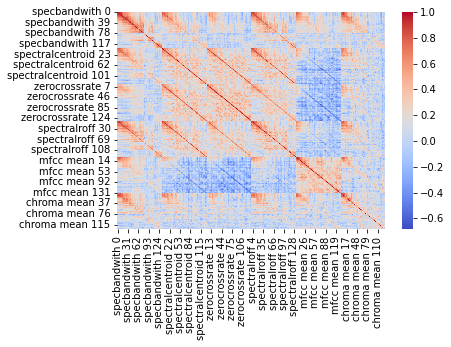

In [680]:
sns.heatmap(pd.DataFrame(X).corr(), cmap='coolwarm')

In [681]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)

PCA()

In [682]:
W = pca.components_
print("Shape of W: ", W.shape)
print("Shape of X", X.shape)

Shape of W:  (134, 798)
Shape of X (134, 798)


In [683]:
pd.DataFrame(W.T)

,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,133
0,-0.050262,-0.036999,0.056235,-0.007286,-0.006669,-0.025629,0.016127,-0.054012,-0.021503,0.023524,...,0.004864,0.002069,0.011941,0.031019,0.017326,-0.010216,-0.052795,0.076080,0.010362,-0.013058
1,-0.052309,-0.042868,0.059172,-0.012270,-0.010828,-0.028455,0.028267,-0.054152,-0.005918,0.020438,...,0.000031,0.034526,-0.007153,-0.039680,-0.008925,-0.056574,-0.066600,0.057912,0.084063,-0.016609
2,-0.053668,-0.041426,0.059291,-0.008874,-0.006813,-0.028847,0.026467,-0.053318,-0.009556,0.013125,...,0.046042,-0.004126,-0.008836,0.008519,0.018085,0.041836,0.002875,-0.041880,-0.036274,0.019018
3,-0.052757,-0.042616,0.059263,-0.004550,-0.020483,-0.030031,0.025616,-0.046150,-0.015577,0.011506,...,-0.102400,-0.017960,-0.010570,-0.015399,-0.011045,0.163130,-0.006382,-0.126555,-0.021409,-0.055446
4,-0.053655,-0.041475,0.056966,-0.002223,-0.025158,-0.031789,0.023331,-0.050436,-0.019814,0.017841,...,0.009358,-0.022727,0.045915,0.016783,0.048192,-0.032200,0.048169,-0.031444,-0.120420,-0.080076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,0.010789,-0.007394,-0.011465,-0.027702,0.007684,0.058375,-0.024749,0.029831,-0.028040,-0.026802,...,0.003916,-0.025889,0.035957,0.002450,-0.013884,-0.018532,-0.010895,-0.031259,-0.027548,-0.004983
794,-0.006297,-0.006238,-0.029237,-0.039350,-0.030440,0.060247,0.052887,0.089986,-0.040413,-0.017447,...,-0.011000,0.001947,-0.012517,0.011215,0.008537,0.048067,-0.007271,0.004850,-0.000523,0.082548
795,-0.000436,-0.012297,-0.017728,-0.049968,0.007241,0.050613,-0.007440,0.030533,-0.041595,-0.039957,...,-0.029704,-0.005244,0.005719,0.006239,-0.062277,0.007509,-0.028736,-0.004943,-0.031649,0.032537
796,-0.013374,-0.013770,-0.014195,-0.057584,0.031812,0.071708,-0.022499,0.022980,-0.045791,-0.056179,...,-0.007693,0.016285,-0.013097,0.037036,0.022750,-0.044847,-0.005788,-0.008069,0.020274,-0.020587


In [684]:
W

array([[-0.05026245, -0.05230925, -0.05366779, ..., -0.00043597,
        -0.01337447, -0.0099671 ],
       [-0.0369989 , -0.04286772, -0.04142591, ..., -0.01229708,
        -0.0137697 , -0.00510274],
       [ 0.05623522,  0.05917184,  0.05929084, ..., -0.01772779,
        -0.01419512, -0.00373431],
       ...,
       [ 0.07608025,  0.05791189, -0.04187974, ..., -0.00494307,
        -0.00806947,  0.00601762],
       [ 0.0103625 ,  0.0840625 , -0.03627362, ..., -0.03164914,
         0.02027398,  0.01317947],
       [-0.01305772, -0.01660878,  0.01901848, ...,  0.03253653,
        -0.02058655,  0.01601745]])

In [686]:
W = pd.DataFrame(W.T,
                 index=X.columns,
                 columns=[f'PC{i}' for i in range(1, 135)])

In [687]:
W

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134
specbandwith 0,-0.050262,-0.036999,0.056235,-0.007286,-0.006669,-0.025629,0.016127,-0.054012,-0.021503,0.023524,...,0.004864,0.002069,0.011941,0.031019,0.017326,-0.010216,-0.052795,0.076080,0.010362,-0.013058
specbandwith 1,-0.052309,-0.042868,0.059172,-0.012270,-0.010828,-0.028455,0.028267,-0.054152,-0.005918,0.020438,...,0.000031,0.034526,-0.007153,-0.039680,-0.008925,-0.056574,-0.066600,0.057912,0.084063,-0.016609
specbandwith 2,-0.053668,-0.041426,0.059291,-0.008874,-0.006813,-0.028847,0.026467,-0.053318,-0.009556,0.013125,...,0.046042,-0.004126,-0.008836,0.008519,0.018085,0.041836,0.002875,-0.041880,-0.036274,0.019018
specbandwith 3,-0.052757,-0.042616,0.059263,-0.004550,-0.020483,-0.030031,0.025616,-0.046150,-0.015577,0.011506,...,-0.102400,-0.017960,-0.010570,-0.015399,-0.011045,0.163130,-0.006382,-0.126555,-0.021409,-0.055446
specbandwith 4,-0.053655,-0.041475,0.056966,-0.002223,-0.025158,-0.031789,0.023331,-0.050436,-0.019814,0.017841,...,0.009358,-0.022727,0.045915,0.016783,0.048192,-0.032200,0.048169,-0.031444,-0.120420,-0.080076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chroma mean 128,0.010789,-0.007394,-0.011465,-0.027702,0.007684,0.058375,-0.024749,0.029831,-0.028040,-0.026802,...,0.003916,-0.025889,0.035957,0.002450,-0.013884,-0.018532,-0.010895,-0.031259,-0.027548,-0.004983
chroma mean 129,-0.006297,-0.006238,-0.029237,-0.039350,-0.030440,0.060247,0.052887,0.089986,-0.040413,-0.017447,...,-0.011000,0.001947,-0.012517,0.011215,0.008537,0.048067,-0.007271,0.004850,-0.000523,0.082548
chroma mean 130,-0.000436,-0.012297,-0.017728,-0.049968,0.007241,0.050613,-0.007440,0.030533,-0.041595,-0.039957,...,-0.029704,-0.005244,0.005719,0.006239,-0.062277,0.007509,-0.028736,-0.004943,-0.031649,0.032537
chroma mean 131,-0.013374,-0.013770,-0.014195,-0.057584,0.031812,0.071708,-0.022499,0.022980,-0.045791,-0.056179,...,-0.007693,0.016285,-0.013097,0.037036,0.022750,-0.044847,-0.005788,-0.008069,0.020274,-0.020587


In [696]:
X_proj = pca.transform(X)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, 135)])
X_proj

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134
0,-23.157222,22.224776,7.807559,1.493831,-1.785435,2.600296,0.902264,0.535527,-1.676496,-0.166560,...,-1.942890e-15,9.992007e-16,3.330669e-16,7.632783e-16,-6.383782e-16,-1.554312e-15,-4.440892e-16,3.219647e-15,6.166942e-16,-9.992007e-16
1,-23.157222,22.224776,7.807559,1.493831,-1.785435,2.600296,0.902264,0.535527,-1.676496,-0.166560,...,-1.942890e-15,9.992007e-16,3.330669e-16,7.632783e-16,-6.383782e-16,-1.554312e-15,-4.440892e-16,3.219647e-15,6.166942e-16,-9.992007e-16
2,-23.157222,22.224776,7.807559,1.493831,-1.785435,2.600296,0.902264,0.535527,-1.676496,-0.166560,...,-1.942890e-15,9.992007e-16,3.330669e-16,7.632783e-16,-6.383782e-16,-1.554312e-15,-4.440892e-16,3.219647e-15,6.166942e-16,-9.992007e-16
3,-6.171765,-4.632394,-1.956543,-1.128971,-0.936384,2.210222,3.229370,-9.603648,0.601693,0.737029,...,2.803313e-15,1.110223e-16,-1.075529e-16,-9.853229e-16,1.290634e-15,-9.853229e-16,-2.137179e-15,4.163336e-15,2.331468e-15,-4.232725e-16
4,-6.171765,-4.632394,-1.956543,-1.128971,-0.936384,2.210222,3.229370,-9.603648,0.601693,0.737029,...,2.803313e-15,1.110223e-16,-1.075529e-16,-9.853229e-16,1.290634e-15,-9.853229e-16,-2.137179e-15,4.163336e-15,2.331468e-15,-4.232725e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,7.294101,-2.321522,-3.270743,-0.327004,-2.533216,6.159926,-12.466696,4.689899,7.585718,-4.652819,...,-1.387779e-15,-2.498002e-16,-4.024558e-16,-2.220446e-16,-9.436896e-16,1.748601e-15,2.498002e-16,-2.942091e-15,-1.110223e-15,2.151057e-16
130,7.294101,-2.321522,-3.270743,-0.327004,-2.533216,6.159926,-12.466696,4.689899,7.585718,-4.652819,...,-1.387779e-15,-2.498002e-16,-4.024558e-16,-2.220446e-16,-9.436896e-16,1.748601e-15,2.498002e-16,-2.942091e-15,-1.110223e-15,2.151057e-16
131,-13.434492,-4.905328,-6.330425,-7.530349,-4.253882,-3.550409,0.143571,-2.347046,0.904700,1.844197,...,4.996004e-16,-4.996004e-16,-5.551115e-16,-1.207368e-15,3.920475e-16,9.679757e-16,-7.216450e-16,1.665335e-15,1.457168e-15,1.776357e-15
132,-13.434492,-4.905328,-6.330425,-7.530349,-4.253882,-3.550409,0.143571,-2.347046,0.904700,1.844197,...,4.996004e-16,-4.996004e-16,-5.551115e-16,-1.207368e-15,3.920475e-16,9.679757e-16,-7.216450e-16,1.665335e-15,1.457168e-15,1.776357e-15


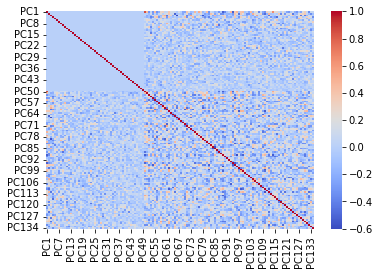

In [697]:
sns.heatmap(X_proj.corr(), cmap='coolwarm');


In [698]:
# Compute PCs
eig_vals, eig_vecs = np.linalg.eig(np.dot(X.T,X))

In [699]:
# Show all 84 principal components (unranked)
W = pd.DataFrame(eig_vecs, 
                 index=X.columns,
                 columns=[f'PC{i}' for i in range(1, 135)])
W


ValueError: Shape of passed values is (798, 798), indices imply (798, 134)

In [694]:
# Let's compute it
X_proj.std()**2 / ((X.std()**2).sum())

PC1      1.908000e-01
PC2      1.156412e-01
PC3      7.246531e-02
PC4      5.182658e-02
PC5      3.790259e-02
             ...     
PC130    1.086973e-32
PC131    7.387987e-33
PC132    6.942606e-33
PC133    8.812512e-33
PC134    2.880506e-33
Length: 134, dtype: float64

In [ ]:
pca.explained_variance_ratio_


In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [ ]:
# Fit a PCA with only 10 components
pca3 = PCA(n_components=10).fit(X)

# Project your data into 3 dimensions
X_proj10 = pd.DataFrame(pca3.fit_transform(X), columns=[f'PC{i}' for i in range(1, 11)])

# We have "compressed" our dataset in 3D
X_proj10

In [ ]:
#X_reconstructed = pca3.inverse_transform(X_proj3)
#X_reconstructed.shape
#pd.DataFrame(X_reconstructed)

### Testing model performance

In [675]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(tsne_result, y_cat)

cv_forest = cross_validate(random_forest, tsne_result, y_cat, cv=5, scoring=('accuracy', 'f1_samples'))
forest_accuracy = cv_forest['test_accuracy'].mean()
forest_f1 = cv_forest['test_f1_samples'].mean()

print('accuracy =', forest_accuracy)
print('f1 =', forest_f1)

accuracy = 0.14871794871794872
f1 = 0.14871794871794872


In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical

y = df['style']
labelencoder=LabelEncoder()
labelencoder.fit(y)
y_transformed = labelencoder.transform(y)


y_cat = to_categorical(y_transformed)
y_cat

In [ ]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier


classifier = MultiOutputClassifier(XGBClassifier())

classifier.fit(X_proj10, y_cat)

cv_xgb = cross_validate(classifier, X_proj10, y_cat, cv=5, scoring=('accuracy', 'f1_samples'))
xgb_accuracy = cv_xgb['test_accuracy'].mean()
xgb_f1 = cv_xgb['test_f1_samples'].mean()

print('accuracy =', xgb_accuracy)
print('f1 =', xgb_f1)

In [ ]:
cv_xgb

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_proj10, y_cat)

cv_forest = cross_validate(random_forest, X_proj10, y_cat, cv=5, scoring=('accuracy', 'f1_samples'))
forest_accuracy = cv_forest['test_accuracy'].mean()
forest_f1 = cv_forest['test_f1_samples'].mean()

print('accuracy =', forest_accuracy)
print('f1 =', forest_f1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

knn_model = KNeighborsClassifier()
cv_results_knn = cross_validate(knn_model, X_proj10, y_cat, cv=5, scoring=('accuracy', 'f1_samples'))

knn_accuracy = cv_results_knn['test_accuracy'].mean()
knn_f1 = cv_results_knn['test_f1_samples'].mean()

print('accuracy =', knn_accuracy)
print('f1 =', knn_f1)

### T-SNE Analysis

In [700]:
X.shape

(134, 798)

In [703]:
from sklearn.manifold import TSNE
tsne = TSNE()

tsne.fit(X)

W_tsne = tsne.embedding_
print("Shape of W: ", W.shape)
print("Shape of X", X.shape)

/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Shape of W:  (798, 134)
Shape of X (134, 798)


In [705]:
#W_tsne = pd.DataFrame(W_tsne.T,
             #    index=X.columns,
             #    columns=[f'PC{i}' for i in range(1, 135)])

In [ ]:
pd.DataFrame(W_tsne)

In [706]:
tsne_result = tsne.fit_transform(X)
tsne_result.shape

/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(134, 2)

In [707]:
tsne_result

array([[  1.8399472 , -14.106903  ],
       [  1.0566077 , -13.806924  ],
       [  1.5318142 , -13.724064  ],
       [  2.9734836 ,  -2.715501  ],
       [  3.2076695 ,  -2.645063  ],
       [  3.3549914 ,  -2.7376893 ],
       [-13.486598  ,  -5.737742  ],
       [-13.79216   ,  -5.9208026 ],
       [-13.5157385 ,  -6.085787  ],
       [ -1.7912072 ,   4.983792  ],
       [ -1.9334651 ,   4.789857  ],
       [ -2.047068  ,   5.0831766 ],
       [  7.261161  ,   5.688824  ],
       [  7.0996103 ,   5.8995147 ],
       [  7.261161  ,   5.688824  ],
       [-11.139955  ,   3.5932603 ],
       [-11.1817    ,   3.3096688 ],
       [-11.139955  ,   3.5932603 ],
       [  4.8077292 , -11.550162  ],
       [ -4.022069  ,   8.855097  ],
       [  2.0451994 ,   9.371835  ],
       [  2.3268497 ,   9.32488   ],
       [  2.1556435 ,   9.128605  ],
       [-14.7816925 ,   0.6919802 ],
       [-14.943359  ,   0.94818044],
       [-15.079164  ,   0.68811876],
       [  0.4705925 ,  -2.55541   ],
 

In [708]:
classifier = MultiOutputClassifier(XGBClassifier())

classifier.fit(tsne_result, y_cat)

cv_xgb = cross_validate(classifier, tsne_result, y_cat, cv=5, scoring=('accuracy', 'f1_samples'))
xgb_accuracy = cv_xgb['test_accuracy'].mean()
xgb_f1 = cv_xgb['test_f1_samples'].mean()

print('accuracy =', xgb_accuracy)
print('f1 =', xgb_f1)

[15:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

/Users/raphaelcommere/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o